In [1]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%%capture
!pip install pandas numpy matplotlib scikit-learn xgboost shap joblib
!pip install catboost lightgbm
!pip install dask[dataframe]

In [3]:
#packages for data handling
import pandas as pd
import numpy as np

#packages for data visualization
import matplotlib.pyplot as plt

#packages for preprocessing
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel

#packages for machine learning models
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

#package for evaluation
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score, RandomizedSearchCV

#package for interpretability
import shap

#package for saving/loading
import joblib


In [5]:
#defining column types to detect/prevent any rows with column misalignment

#read in files from google drive
train_df = pd.read_csv('/content/drive/MyDrive/projects_jff/Forecasts/Kaggle_Insurance/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/projects_jff/Forecasts/Kaggle_Insurance/test.csv')

In [7]:
pd.set_option('display.max_columns', None)  # Display all columns
train_df.head()

,id,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount
0,0,19.0,Female,10049.0,Married,1.0,Bachelor's,Self-Employed,22.598761,Urban,Premium,2.0,17.0,372.0,5.0,2023-12-23 15:21:39.134960,Poor,No,Weekly,House,2869.0
1,1,39.0,Female,31678.0,Divorced,3.0,Master's,NaN,15.569731,Rural,Comprehensive,1.0,12.0,694.0,2.0,2023-06-12 15:21:39.111551,Average,Yes,Monthly,House,1483.0
2,2,23.0,Male,25602.0,Divorced,3.0,High School,Self-Employed,47.177549,Suburban,Premium,1.0,14.0,NaN,3.0,2023-09-30 15:21:39.221386,Good,Yes,Weekly,House,567.0
3,3,21.0,Male,141855.0,Married,2.0,Bachelor's,NaN,10.938144,Rural,Basic,1.0,0.0,367.0,1.0,2024-06-12 15:21:39.226954,Poor,Yes,Daily,Apartment,765.0
4,4,21.0,Male,39651.0,Single,1.0,Bachelor's,Self-Employed,20.376094,Rural,Premium,0.0,8.0,598.0,4.0,2021-12-01 15:21:39.252145,Poor,Yes,Weekly,House,2022.0


In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200000 entries, 0 to 1199999
Data columns (total 21 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   id                    1200000 non-null  int64  
 1   Age                   1181295 non-null  float64
 2   Gender                1200000 non-null  object 
 3   Annual Income         1155051 non-null  float64
 4   Marital Status        1181471 non-null  object 
 5   Number of Dependents  1090328 non-null  float64
 6   Education Level       1200000 non-null  object 
 7   Occupation            841925 non-null   object 
 8   Health Score          1125924 non-null  float64
 9   Location              1200000 non-null  object 
 10  Policy Type           1200000 non-null  object 
 11  Previous Claims       835971 non-null   float64
 12  Vehicle Age           1199994 non-null  float64
 13  Credit Score          1062118 non-null  float64
 14  Insurance Duration    1199999 non-

<Axes: >

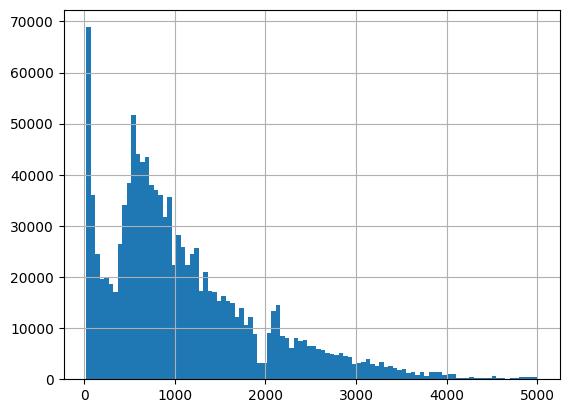

In [18]:
#histogram of train_df on premium amount - checking for imbalance
train_df['Premium Amount'].hist(bins=100)

<Axes: >

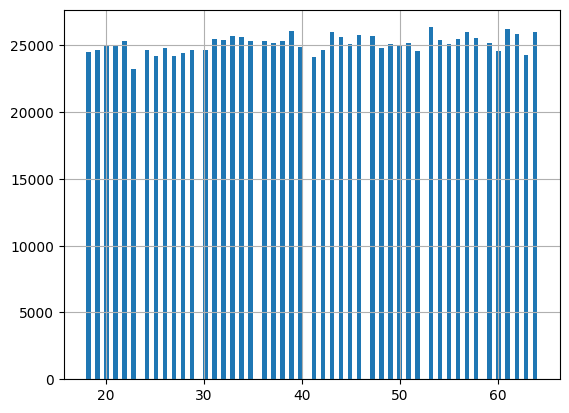

In [24]:
#checking features for missing values
train_df['Age'].hist(bins=100)

In [29]:
#standardize features
train_df['Customer Feedback'].value_counts()

,count
Customer Feedback,
Average,377905
Poor,375518
Good,368753


In [ ]:
train_df.isnull().sum()

In [28]:
train_df.isna().sum()

,0
id,0
Age,18705
Gender,0
Annual Income,44949
Marital Status,18529
Number of Dependents,109672
Education Level,0
Occupation,358075
Health Score,74076
Location,0


In [30]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200000 entries, 0 to 1199999
Data columns (total 21 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   id                    1200000 non-null  int64  
 1   Age                   1181295 non-null  float64
 2   Gender                1200000 non-null  object 
 3   Annual Income         1155051 non-null  float64
 4   Marital Status        1181471 non-null  object 
 5   Number of Dependents  1090328 non-null  float64
 6   Education Level       1200000 non-null  object 
 7   Occupation            841925 non-null   object 
 8   Health Score          1125924 non-null  float64
 9   Location              1200000 non-null  object 
 10  Policy Type           1200000 non-null  object 
 11  Previous Claims       835971 non-null   float64
 12  Vehicle Age           1199994 non-null  float64
 13  Credit Score          1062118 non-null  float64
 14  Insurance Duration    1199999 non-

In [ ]:
#updating missing values with nearest neighbor (Age, Annual Income, Marital Status, Number of Dependents, Occupation, Health Score,
# Previous Claims, Vehicle Age, Credit Score, Insurance Duration, Customer Feedback)

#need to encode categorical features to numeric - need to do the same for the test set